In [1]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] getPass_0.2-2   compiler_3.6.3  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_3.6.3     htmltools_0.4.0 pillar_1.4.4    base64enc_0.1-3
 [9] crayon_1.3.4    Rcpp_1.0.4.6    uuid_0.1-4      IRkernel_1.1   
[13] jsonlite_1.6.1  digest_0.6.25   repr_1.1.0      rlang_0.4.6    
[17] evaluate_0.14  

In [2]:
library(ggplot2)

# Monte Carlo integration

## Naïve Monte Carlo

### Goal

To evaluate $\int_A g(x) dx$, $g:\mathbb{R}^d \to \mathbb{R}$.

More generally, to evaluate $\int_A g(x) w(x)dx$, $g:\mathbb{R}^d \to \mathbb{R}$, for $w(x) > 0$ on $A \subset \mathbb{R}^d$ and $\int_A w(x)dx < \infty$.

* cf. (Gaussian) quadrature: $\int_a^b g(x) w(x)dx$, $g:\mathbb{R} \to \mathbb{R}$, for $w(x) > 0$ on $(a, b)$ and $\int_a^b w(x)dx < \infty$.
* Extension of quadrature methods to $d$ dimension required $n^d$ points (curse of dimensionality)
* Quadrature methods works well mostly with smooth functions.

After appropriate normalization,
$$
    \int_A g(x) f(x)dx = E[g(X)], \quad X \sim F,
$$
where distribution $F$ has density $f$.

By the law of large numbers,
$$
    E[g(X)] \approx \frac{1}{n}\sum_{i=1}^ng(X_i),  \quad X_i \stackrel{iid}{\sim} F
$$
for sufficiently large $n$. This method is called the **Monte Carlo method** for approximating the integral.

The RHS of the above approximate equality, denoted by $\hat{I}_n(f)$ is an *unbiased estimator* of the LHS.

If in addition, if $\text{Var}[g(X)]$ is finite or $g(x)$ is square integrable, the variance of this unbiased estimator is 
$$
\frac{1}{n}\text{Var}[g(X)] = \frac{\int_A g^2(x)f(x)dx - (\int_A g(x)f(x)dx)^2}{n}
$$
and the central limit theorem provides an (approximate) $100(1-\alpha)$% confidence interval
$$
    \left[\hat{I}_n(f) - z_{1-\alpha/2}\frac{\text{Sd}[g(X)]}{\sqrt{n}}, \hat{I}_n(f) + z_{1-\alpha/2}\frac{\text{Sd}[g(X)]}{\sqrt{n}} \right].
$$
Since $\text{Sd}[g(X)]$ is unknown in general, we may use
$$
 \widehat{\text{Sd}[g(X)]} = \left( \frac{1}{n-1}\sum_{i=1}^n[f(X_i) - I_n(f)]^2 \right)^{1/2}.
$$


Therefore we can measure the accuracy of the esitmator $\hat{I}_n(f)$ by the relative error $\widehat{\text{Sd}[g(X)]} / [\hat{I}_n(f)\sqrt{n}]$.

So the key feasures of MC itegration are

1. The error estimate does not depende direcly on the dimsnsionality of the underlying space
2. The error diminisihes at a slow rate of $O(n^{-1/2})$.

On the other hand, quadrature methods (in one dimension) at the rate of $O(n^{-k})$ for $k \ge 2$. If $n = m^d$ points are used in $d$ dimensions, then the error is $O(n^{-k/d})$. So the numerical merit of MC integration over quadrature methods is roughly for $d \ge 4$.

Nevertheless MC has an attraction of very simple implementation: just sample and average.

### Example 1

$$
\int_0^{\infty} \sqrt{x}e^{-x}dx = \frac{\sqrt{\pi}}{2} \approx 0.88627
$$

In [3]:
myfn <- function(x) sqrt(x) * exp(-x)
integrate(myfn, 0, Inf)    # (adaptive) quadrature

0.8862265 with absolute error < 2.5e-06

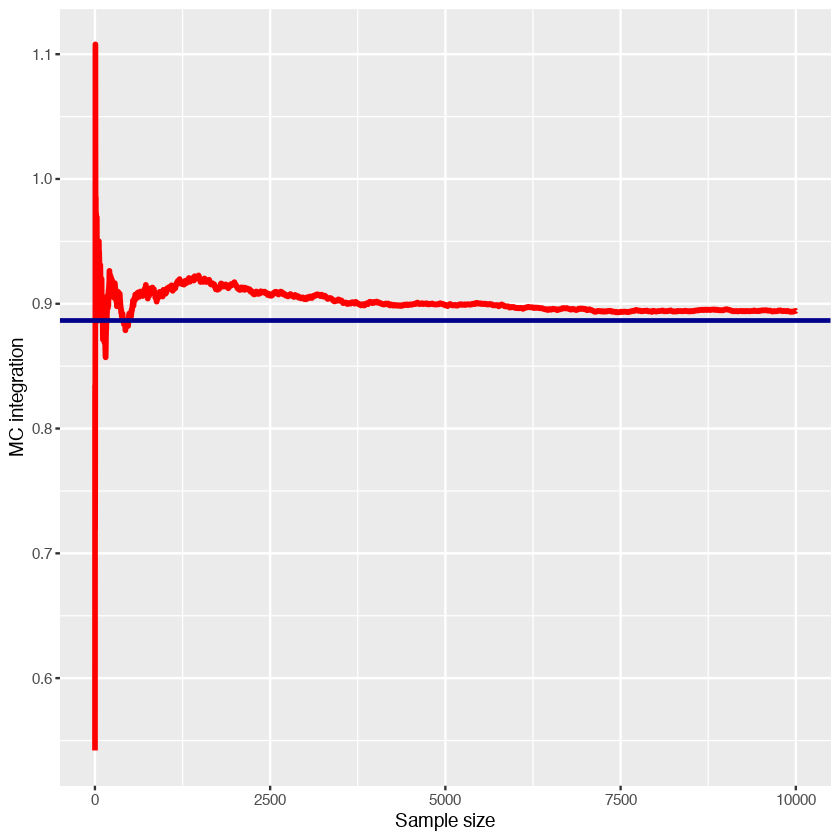

In [4]:
set.seed(2020)
nsamp <- 10000  # try 100000, too
x <- rexp(nsamp, 1)   # X ~ Exp(1)
xsqrt <- sqrt(x)
MCest <- cumsum(xsqrt) / seq_along(xsqrt) # cumulative average
RVdata <- data.frame(nsamp = seq_along(xsqrt), est = MCest)
ggplot(RVdata) + geom_line(aes(x = nsamp, y = est), col="red", lwd=1.2) +
    geom_hline(yintercept = sqrt(pi) * 0.5, col="dark blue", lwd=1) +
    xlab("Sample size") + ylab("MC integration")

### Example 2

$$
\int_0^{1} \frac{1}{\sqrt{x}} = 2
$$

In [5]:
myfn <- function(x) 1 / sqrt(x) 
integrate(myfn, 0, 1)    # (adaptive) quadrature

2 with absolute error < 5.8e-15

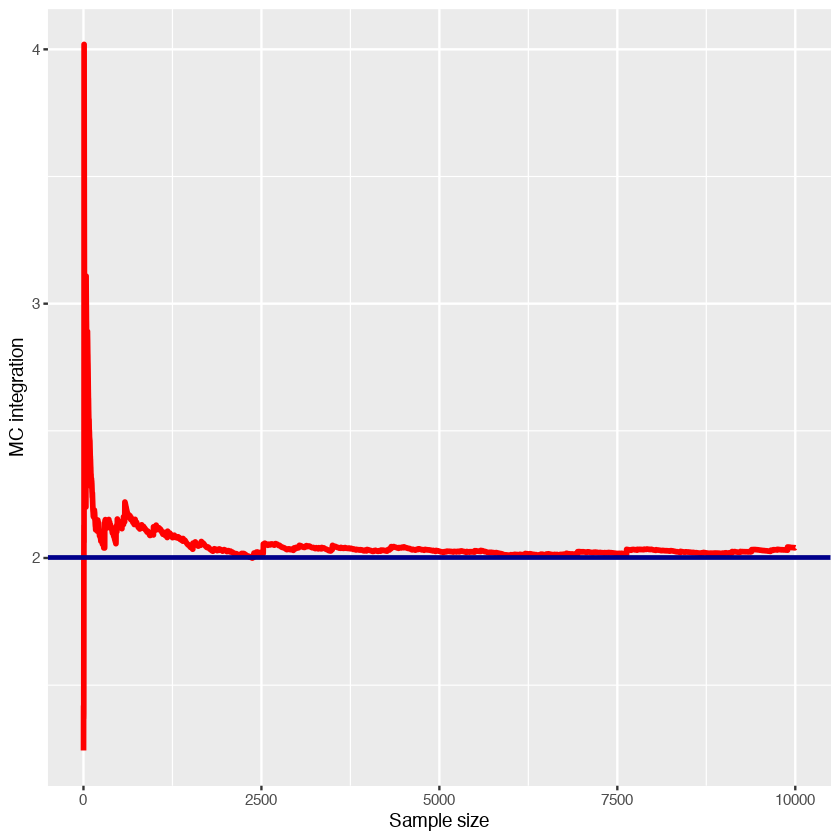

In [6]:
set.seed(2020)
nsamp <- 10000  # try 100000, too
x <- runif(nsamp)   # X ~ unif(0, 1)
xsqrtinv <- 1 / sqrt(x)
MCest <- cumsum(xsqrtinv) / seq_along(xsqrtinv) # cummulative average
RVdata <- data.frame(nsamp = seq_along(xsqrtinv), est = MCest)
ggplot(RVdata) + geom_line(aes(x = nsamp, y = est), col="red", lwd=1.2) +
    geom_hline(yintercept = 2, col="dark blue", lwd=1) +
    xlab("Sample size") + ylab("MC integration")

Accuracy of this MC integration depends on 
$$
    \text{Var}[1/\sqrt{X}] = E[1 / X] - E[1 / \sqrt{X}]^2 = \int_0^1 \frac{1}{x}dx - 2^2 = \infty
$$

So the naïve MC is not a good estmator of the integral.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


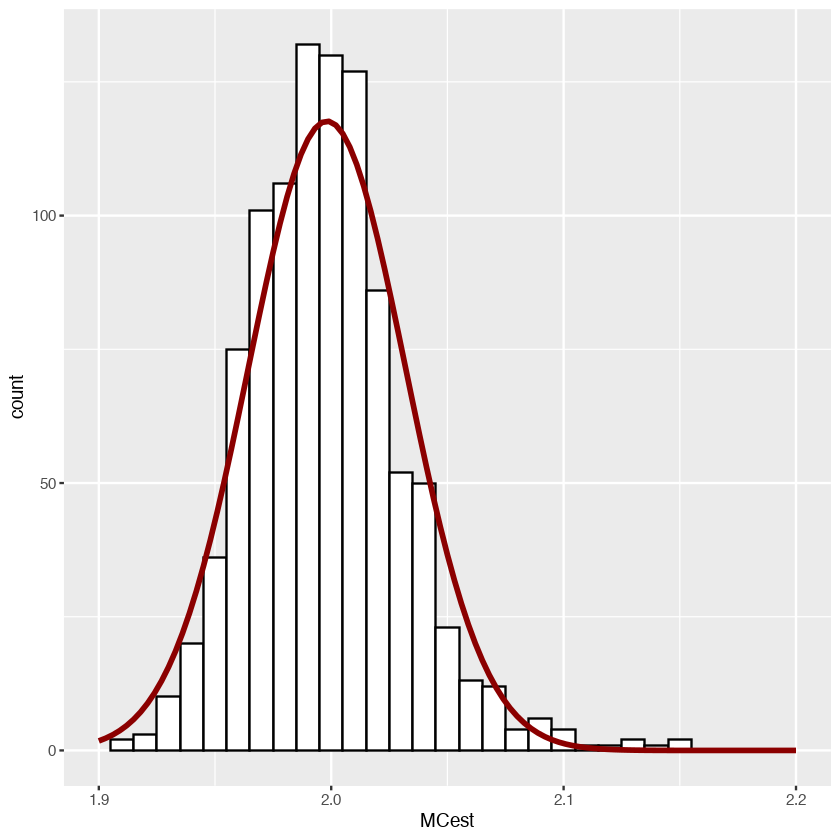

In [7]:
set.seed(2020)
nsim <- 1000
nsamp <- 10000  # try 100000, too
x <- runif(nsamp * nsim)   # X ~ unif(0, 1)
xsqrtinv <- 1 / sqrt(x)
MCest <- apply(matrix(xsqrtinv, nrow = nsim), 1, mean)
MCerr <- var(MCest)
RVdata <- data.frame(MCest = MCest)
ggplot(RVdata, aes(x = MCest)) + geom_histogram(binwidth = 0.01, col="black", fill="white") +
    stat_function(
        fun  = function(x, mean, sd, n, bw) dnorm(x = x, mean = mean, sd = sd) * n * bw,
        args = c(mean = mean(MCest), sd = sqrt(MCerr), n = nsim, bw = 0.01),
        lwd  = 1.2, col = "dark red"
    ) +
    xlim(c(1.9, 2.2))

A better approach is change of variable: let $t = \sqrt{x}$. Then $dt = \frac{1}{2\sqrt{x}}dx$ and,
$$
    \int_0^1 \frac{1}{\sqrt{x}}dx = \int_0^1 2dt
$$

Thus the MC estimate of the RHS is $\frac{1}{n}\sum_{i=1}^n 2 = 2$, exact.

In general, if integrand gets closer to a constat, then  MC gets more accurate.

### Digression: Buffon's needle

> A table is ruled with equidistant parallel lines a distance $D$ apart. A needle of length $L$, where $L \le D$, is randomly thrown on the table. What is the probability that the needle will intersect one of the lines (the other possibility being that the needle will be completely contained in the strip between two lines)?


![Buffon's needle](./buffon.png)

* Let $X$ be the distance from the needle to the nearest parallel line.

* Let $\Theta$ be the angle between the needle and the projected line of length $X$.

* The needle will intersect a line if the hypotenuse of the right triangle is less that $L/2$, or
$X < \frac{L}{2}\cos\Theta$.

It is reasonable to assume that $X$ and $\Theta$ are independent, uniformly distributed in $[0, D/2]$ and $[0, \pi/2]$. Hence
$$
\begin{aligned}
	P(X < \frac{L}{2}\cos\Theta ) &= E\left[\mathbb{I}\{X < \frac{L}{2}\cos\Theta\}\right] \\
    &= \iint_{x<0.5L\cos \theta}f_X(x)f_{\Theta}(\theta) dxd\theta \\
	&= \frac{4}{\pi D}\int_0^{\pi/2}\int_0^{0.5L\cos\theta} dxd\theta \\
	&= \frac{4}{\pi D}\int_0^{\pi/2}\frac{L}{2}\cos\theta d\theta
	= \frac{2L}{\pi D}
	.
\end{aligned}
$$ 

Italian mathematician Mario Lazzarini (1901) used this result to estimate the value of $\pi$. How?

* Set $D=1$, $L = D/2 = 1/2$.
* If in $n$ trials, $k$ hits occur, then $\pi \approx n/k$.

,nsamp,est
,<int>,<dbl>
99995,99995,3.105435
99996,99996,3.105369
99997,99997,3.105304
99998,99998,3.105239
99999,99999,3.105173
100000,100000,3.105108


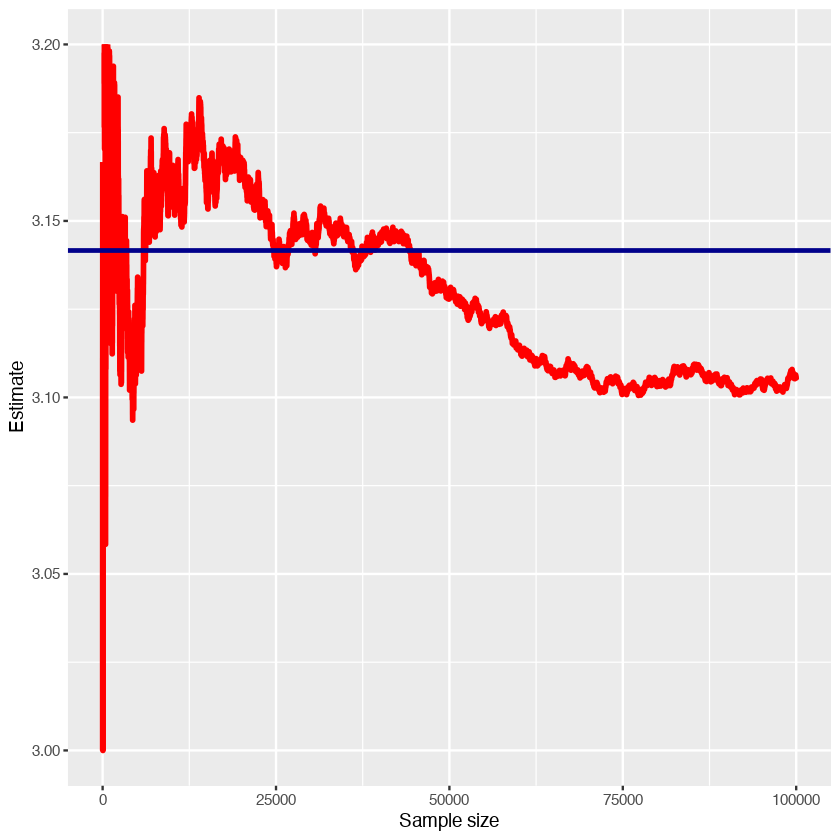

In [8]:
set.seed(2020)
nsamp <- 100000  # try 500000, too
x <- runif(nsamp) * 0.5   # X ~ unif(0, 1/2)
thet <- runif(nsamp) * pi / 2   # theta ~ unif(0, pi/2)
numhits <- (x < 0.25 * cos(thet))
pihat <- seq_along(numhits) / cumsum(numhits) 
RVdata <- data.frame(nsamp = seq_along(numhits), est = pihat)
tail(RVdata)
ggplot(RVdata) + geom_line(aes(x = nsamp, y = est), col="red", lwd=1.2) +
    geom_hline(yintercept = pi, col="dark blue", lwd=1) +
    xlab("Sample size") + ylab("Estimate") + ylim(3.0, 3.2)

## Variance reduction methods

We live with the $O(n^{-1/2})$ convergence rate of MC, and attempt to reduce the constant factor, i.e., the $\sqrt{\text{Var}[g(X)]}$ part.

### Importance sampling

In evaluating
$$
I = \int_{-\infty}^{\infty} g(x) f(x)dx = E_f[g(X)],
$$
consider instead
$$
I = \int_{-\infty}^{\infty} g(x) f(x)dx = \int_{-\infty}^{\infty} \frac{g(x)f(x)}{h(x)} h(x)dx
= E_h\left[\frac{g(X)f(X)}{h(X)}\right]
$$
for another density $h(x)$ such that $h(x) > 0$ whenever $g(x)f(x) \neq 0$.

If it is easy to sample from the distribution with density $h(x)$, then we may estimate $I$ by
$$
\hat{I}_{\text{imp}} = \frac{1}{n}\sum_{i=1}^n\frac{g(X_i)f(X_i)}{h(X_i)},
\quad
X_i \stackrel{iid}{\sim} h
$$
instead of the simple estimator
$$
\hat{I}_{\text{naive}} = \frac{1}{n}\sum_{i=1}^n f(X_i), 
\quad
X_i \stackrel{iid}{\sim} f
.
$$

It is obvious that both $\hat{I}_{\text{imp}}$ and $\hat{I}_{\text{naive}}$ are  unbiased estimators of $I$.

The variance of $\hat{I}_{\text{imp}}$ is smaller than that of $\hat{I}_{\text{naive}}$ if and only if
$$
    E_h\left[\left(\frac{g(X)f(X)}{h(X)}\right)^2\right] \le E_f[g^2(X)]
$$
or
$$
    \int_{-\infty}^{\infty}\left(\frac{g(x)f(x)}{h(x)}\right)^2 h(x)dx
    \le 
    \int_{-\infty}^{\infty}g^2(x) f(x) dx
$$

First note that
\begin{align*}
    \left(\int_{-\infty}^{\infty}|g(x)|f(x)dx\right)^2 
    &=
    \left(\int_{-\infty}^{\infty} \frac{|g(x)|f(x)}{\sqrt{h(x)}}\sqrt{h(x)}dx \right)^2 \\
    &\le
    \int_{-\infty}^{\infty} \frac{g^2(x)f^2(x)}{h(x)} dx \int_{-\infty}^{\infty}h(x)dx \\
    &=
    \int_{-\infty}^{\infty} \left(\frac{g(x)f(x)}{h(x)}\right)^2h(x) dx \cdot (1) \\
    &= E\left[\left(\frac{g(X)f(X)}{h(X)}\right)^2\right]
    ,
\end{align*}
where the inequality is Cauchy-Schwarz. Equality holds if and only if $\frac{|g(x)|f(x)}{\sqrt{h(x)}}= c\sqrt{h(x)}$ for some $c > 0$ for all $x$, i.e., $h(x) \propto |g(x)|f(x)$.

So if we choose $h(x) = \frac{|g(x)|f(x)}{\int |g(u)|f(u)du}$, then
\begin{align*}
    \int_{-\infty}^{\infty}\left(\frac{g(x)f(x)}{h(x)}\right)^2 h(x)dx
    &=
    \left(\int_{-\infty}^{\infty}|g(x)|f(x)dx\right)^2 \\
    &\le
    \int_{-\infty}^{\infty} g^2(x)f(x)dx \int_{-\infty}^{\infty}f(x)dx \\
    &= 
    \int_{-\infty}^{\infty} g^2(x)f(x)dx
    .
\end{align*}
The middle inequality is again Cauchy-Schwarz. Equality holds if and only if $|g(x)|\sqrt{f(x)} = c\sqrt{f(x)}$ for some $c \ge 0$, or $|g(x)|$ is constant.


* The minimum variance of $\hat{I}_{\text{imp}}$ is $\frac{1}{n}[(E_f|g(X)|)^2 - I^2]$.
    - If $g$ is nonnegative, then the variance can be zero!

* However, $\int |g(u)|f(u)du$ is unknown.

* The above argument tells us that if we choose $h(x)$ close to be proportional to $|g(x)|f(x)$, then the variance is strictly reduced. <!--unless $g(x)$ is uninteresting.-->

#### Example: normal probability

Suppose we want to estimate the tail probability of standard normal:
$$
\pi(c) = \int_c^{\infty}\phi(x)dx = 1 - \Phi(c) = \Phi(-c),
$$
where $\phi(x) = \frac{1}{\sqrt{2\pi}}e^{-x^2/x}$ and $\Phi$ is the cdf of standard normal.

1. Naive MC

We can write this probability as 
$$
    \pi(c) = \int_{-\infty}^{\infty}\mathbb{I}_{\{x > c\}}\phi(x)dx.
$$

$$
    \hat{\pi}_{\text{naive}}(c) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}_{\{Z_i > c\}},
    \quad
    Z_i \stackrel{iid}{\sim} N(0, 1)
    .
$$
Obviously, $E[\hat{\pi}_{\text{naive}}(c)] = \pi(c)$ and $\text{Var}[\hat{\pi}_{\text{naive}}(c)] = \frac{1}{n}\pi(c)( 1 - \pi(c))$.

2. Importance sampling

We can alternatively write the probability $\pi(c)$ as 
$$
    \pi(c) = \int_{-\infty}^{\infty}\mathbb{I}_{\{x > c\}}\frac{\phi(x)}{\phi(x-c)}\phi(x-c)dx
    = \int_{-\infty}^{\infty}\mathbb{I}_{\{x > c\}}\exp\left(-cx + \frac{1}{2}c^2\right)\phi(x-c)dx
$$
Hence
\begin{align*}
    \hat{\pi}_{\text{imp}}(c) &= \frac{e^{c^2/2}}{n}\sum_{i=1}^n \mathbb{I}_{\{X_i > c\}}\exp(-cX_i),
    \quad
    X_i \stackrel{iid}{\sim} N(c, 1) \\
    &= \frac{e^{c^2/2}}{n}\sum_{i=1}^n \mathbb{I}_{\{Z_i > 0\}}\exp(-c[Z_i + c]),
    \quad
    Z_i \stackrel{iid}{\sim} N(0, 1) \\
    .
\end{align*}

It is clear $E[\hat{\pi}_{\text{imp}}(c)] = \pi(c)$. To evaluate the variance, for $X \sim N(0,1)$,
\begin{align*}
    E[\mathbb{I}_{\{X > c\}}\exp(-cX)]
    &= \int_c^{\infty}\exp(-cx)\phi(x-c)dx \\
    &= \int_c^{\infty}\exp(-cx)\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}(x-c)^2\right)dx \\
    &= \int_c^{\infty}\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}(x+c)^2\right)dx \\
    &= \int_{2c}^{\infty}\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}z^2\right)dz \\
    &= 1 - \Phi(2c) = \Phi(-2c).
\end{align*}
Therefore,
$$
    \text{Var}[\hat{\pi}_{\text{imp}}(c)] = \frac{1}{n}\left(e^{c^2}\Phi(-2c) - [\pi(c)]^2\right).
$$


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


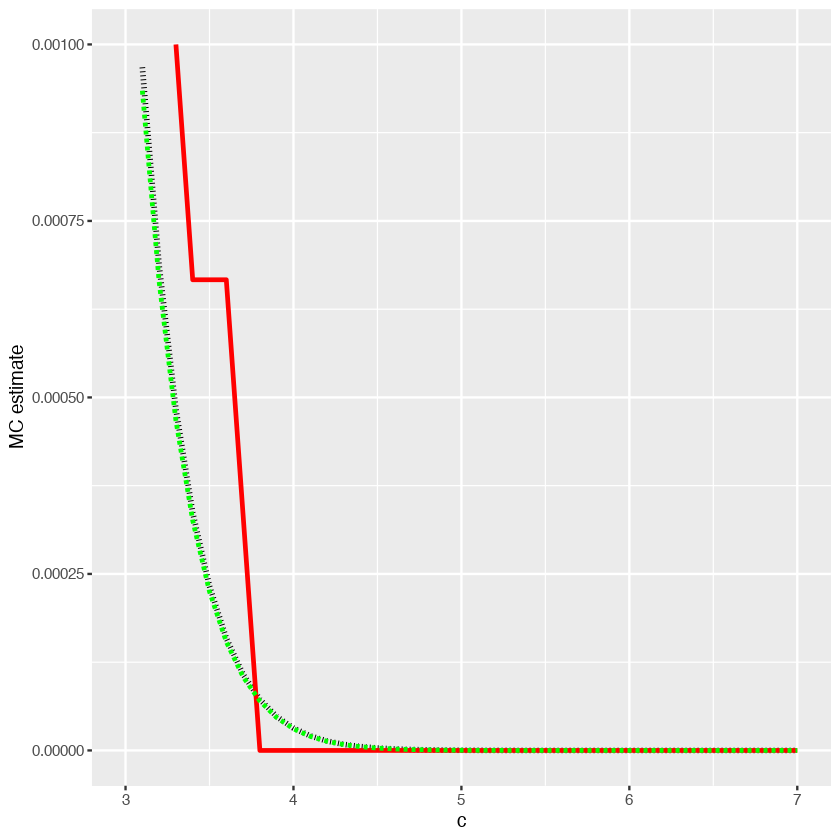

In [9]:
set.seed(2020)
nsamp <- 3000

z <- rnorm(nsamp)   # standard normal sample

cvals <- seq(3.0, 7.0, by=0.1)
nsim <- length(cvals)

naiveMC <- numeric(nsim)
naiveSD <- numeric(nsim)
impMC <- numeric(nsim)
impSD <- numeric(nsim)
varratio <- numeric(nsim)

truepi <- pnorm(-cvals)  # true values
for (k in seq_along(cvals)) {
    cval <- cvals[k]
    indic <- (z > cval)
    naiveMC[k] <- mean(indic)
    naiveSD[k] <- sd(indic) / sqrt(nsim)
    indic2 <- exp(0.5 * cval^2 ) * (z > 0) * exp(-cval * (z + cval))
    impMC[k] <- mean(indic2)
    impSD[k] <- sd(indic2) / sqrt(nsim)
    varratio <- (impSD[k] / naiveSD[k])^2
}

RVdata <- data.frame(cvals, truepi, naiveMC, impMC, varratio)
ggplot(RVdata, aes(x = cvals, y = truepi)) +
    geom_line(col = "black", linetype = 3, lwd = 1.2) +
    geom_line(aes(x = cvals, y = naiveMC), col = "red", linetype = 1, lwd = 1) +
    geom_line(aes(x = cvals, y = impMC), col = "green", linetype = 2, lwd = 1) +
    ylim(0, 0.001) +
    xlab("c") + ylab("MC estimate")

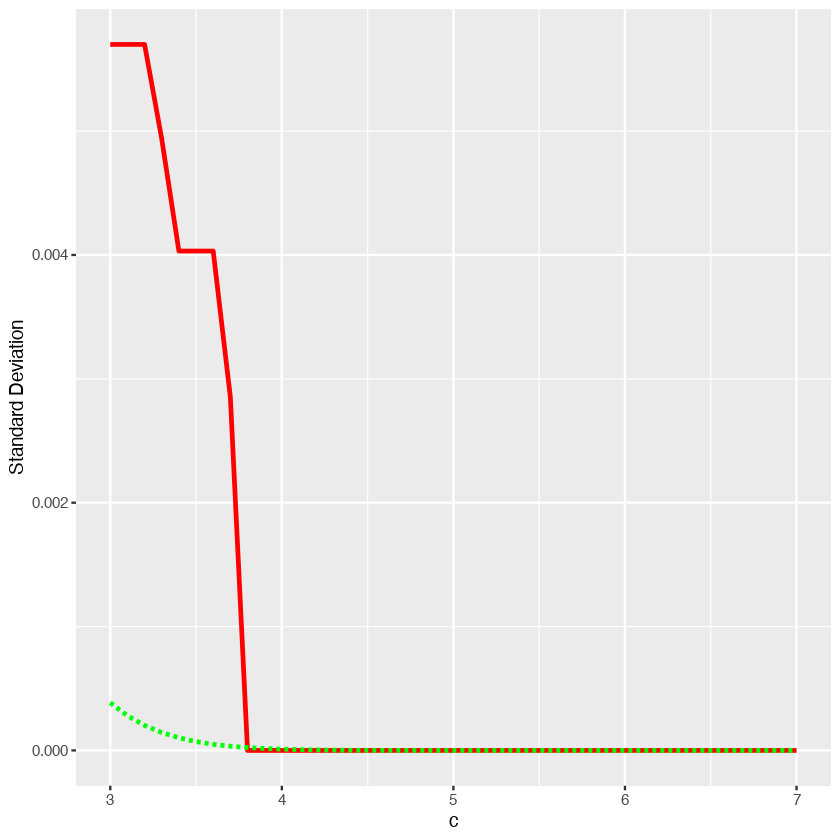

In [10]:
ggplot(RVdata) + 
    geom_line(aes(x = cvals, y = naiveSD), col = "red", linetype = 1, lwd = 1) +
    geom_line(aes(x = cvals, y = impSD), col = "green", linetype = 2, lwd = 1) +
    xlab("c") + ylab("Standard Deviation")

### Antithetic variable method

If both $I_1$ and $I_2$ are unbiased estimators of integral $I$, then
$$
    \text{Var}\left[\frac{I_1 + I_2}{2}\right] 
    = \frac{1}{4}\text{Var}[I_1] + \frac{1}{4}\text{Var}[I_2] + \frac{1}{2}\text{Cov}(I_1, I_2)
    .
$$

If $I_1$ and $I_2$ are negatively correlated, 
$$
    \text{Var}\left[\frac{I_1 + I_2}{2}\right] 
    \le \frac{1}{4}\text{Var}[I_1] + \frac{1}{4}\text{Var}[I_2]
    .
$$
So if we can find pairs of unbiased estimators of the interal, then the variance of the sample mean is these esitmators will be smaller than that of independent estimators.

**Proposition 1**. Suppose $X$ is a random variable and the functions $g_1(x)$ and $g_2(x)$ are both nonincreasing or both nondecreasing in $x$. If the random variables $g_1(X)$ and $g_2(X)$ have finite second moments, then
$$
    \text{Cov}(g_1(X), g_2(X)) \ge 0.
$$
*Proof*. Consider another random variable $Y$ that is i.i.d. to $X$. By monotonicity,
$$
    [g_1(X) - g_1(Y)][g_2(X) - g_2(Y)] \ge 0.
$$
Hence, 
\begin{align*}
    0 &\le E[g_1(X) - g_1(Y)][g_2(X) - g_2(Y)]  \\
      &=E[g_1(X)g_2(X)] + E[g_1(Y)g_2(Y)] - E[g_1(X)]E[g_2(Y)] - E[g_1(Y)]E[g_2(X)]  \\
      &= 2\text{Cov}(g_1(X), g_2(X))
      .
\end{align*}
QED.

Now suppose we want to evaluate the integral $I = \int_{-\infty}^{\infty}g(x)f(x)dx$ for $g(x)$ increasing and $f(x)$ be a density with cdf $F(x)$. If $X \sim F$, then $g(X)$ is an unbiased estimator of $I$. Such a random variable $X$ can be constructed by the inverse cdf method: for $U \sim \text{unif}(0, 1)$, it follows that $F^{-1}(U) \sim F$, i.e., $I_1 = g(F^{-1}(U))$ is an unbiased estimator of $I$. Likewise, for the same random variable $U$, $I_2 = g(F^{-1}(1-U))$ is an unbiased estimator of $I$. Note that $g(F^{-1}(u))$ is nondecreasing in $u$ and $g(F^{-1}(1-u))$ is nonincreasing in $u$. By Proposition 1, $\text{Cov}(I_1, I_2) \le 0$. It follows that
$$
    \hat{I}_{\text{an}} = \frac{1}{2n}\sum_{i=1}^n[g(F^{-1}(U_i) + g(F^{-1}(1-U_i)],
    \quad
    U_1, \dotsc, U_n \stackrel{iid}{\sim} \text{unif}(0,1) 
$$
has smaller variance than the naïve MC with  the same sample size
$$
    \hat{I}_{\text{naive}} = \frac{1}{n}\sum_{i=1}^{n}g(F^{-1}(U_i))
    .
$$

Another way to obtain antithetic variables is to exploit symmetry. If $f$ is symmeric around the point $\mu$, then $X - \mu \stackrel{d}{=} \mu - X$, or $2\mu - X \stackrel{d}{=} X$. Therefore, we can use $I_1 = g(X_i)$ and $I_2 = g(2\mu - X_i)$ for $X_i \stackrel{iid}{\sim} F$.

#### Example: exponential integral

$$
    I = \int_0^1 e^u du = e - 1 \approx 1.71828
$$

1. Naïve MC
$$
    \hat{I}_{\text{naive}} = \frac{1}{n}\sum_{i=1}^n \exp(U_i), \quad
    U_i \stackrel{iid}{\sim} \text{unif}(0, 1)
    .
$$
We have
\begin{align*}
    E[\hat{I}_{\text{naive}}] &= E[e^{U}] = I \\
    \text{Var}[\hat{I}_{\text{naive}}] &= \frac{1}{n}\text{Var}[e^U] = \frac{1}{n}\left(\frac{e^2-1}{2} - (e-1)^2\right) \approx \frac{0.2420}{n}.
\end{align*}

2. Antithetic MC
$$
    \hat{I}_{\text{an}} = \frac{1}{2n}\sum_{i=1}^n [\exp(U_i) + \exp(1 - U_i)], \quad
    U_i \stackrel{iid}{\sim} \text{unif}(0, 1)
    .
$$

We have 
\begin{align*}
    E[\hat{I}_{\text{as}}] &= \frac{1}{2}(E[e^U] + E[e^{1-U}]) = I \\
    \text{Var}[\hat{I}_{\text{as}}] &= \frac{1}{n}\text{Var}\left[\frac{e^U + e^{1-U}}{2}\right] = \frac{1}{n}\frac{\text{Var}[e^U] + \text{Var}[e^{1-U}] + 2\text{Cov}(e^U, e^{1-U})}{4} \\
    &= \frac{1}{4n}(e^2 - 1 - 2(e-1)^2 +  2(e - (e-1)^2) \\
    &\approx \frac{0.0039}{n}.
\end{align*}



Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


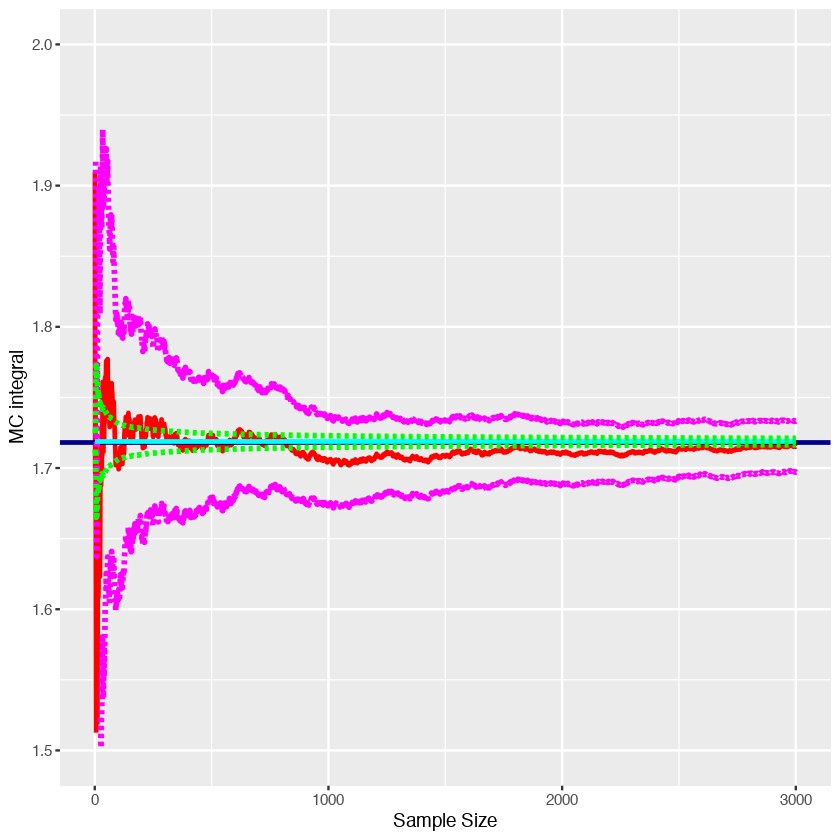

In [11]:
cummean <- function (x) cumsum(x) / seq_along(x)  # cumulative mean
cumvar <- function (x, sd = FALSE) {  # cumulative variance or sd
  x <- x - x[sample.int(length(x), 1)]  
  n <- seq_along(x)
  v <- (cumsum(x ^ 2) - cumsum(x) ^ 2 / n) / (n - 1)
  if (sd) v <- sqrt(v)
  v
}

set.seed(2020)

nsamp <- 3000

u <- runif(nsamp)   # uniform random sample


naive <- exp(u)
naiveMC <- cummean(naive)
naiveSD <- cumvar(naive, sd = TRUE) / sqrt(seq_along(naive))
antithetic <- (exp(u) + exp(1 - u)) * 0.5
antiMC  <- mean(antithetic)
antiSD  <- cumvar(antithetic, sd = TRUE) / sqrt(seq_along(antithetic))
varratio <- (antiSD / naiveSD)^2


RVdata <- data.frame(nsamp = seq_len(nsamp), naiveMC = naiveMC, 
                     naiveUpper = naiveMC + 2 * naiveSD, naiveLower = naiveMC - 2 * naiveSD,
                     antiMC = antiMC,
                     antiUpper = antiMC + 2 * antiSD, antiLower = antiMC - 2 * antiSD,
                     varratio = varratio)
ggplot(RVdata, aes(x = nsamp, y = naiveMC)) +
    geom_line(col = "red", lwd = 1) +
    #geom_point(shape = 16, col = "black", lwd = 1.7) +
    geom_hline(yintercept = exp(1) - 1, col = "dark blue", lwd = 1) +
    geom_line(aes(x = nsamp, y = naiveUpper), col = "magenta", lwd = 1.2, linetype = 2) +
    geom_line(aes(x = nsamp, y = naiveLower), col = "magenta", lwd = 1.2, linetype = 2) +
    ylim(1.5, 2.0) +
    xlab("Sample Size") + ylab("MC integral") +
    geom_line(aes(x = nsamp, y = antiMC), col = "cyan", lwd = 1) +
    #geom_point(shape = 16, col = "black", lwd = 1.7) + 
    geom_line(aes(x = nsamp, y = antiUpper), col = "green", lwd = 1.2, linetype = 2) + 
    geom_line(aes(x = nsamp, y = antiLower), col = "green", lwd = 1.2, linetype = 2) 

Warning message:
“Removed 23 rows containing missing values (geom_point).”
Warning message:
“Removed 23 row(s) containing missing values (geom_path).”


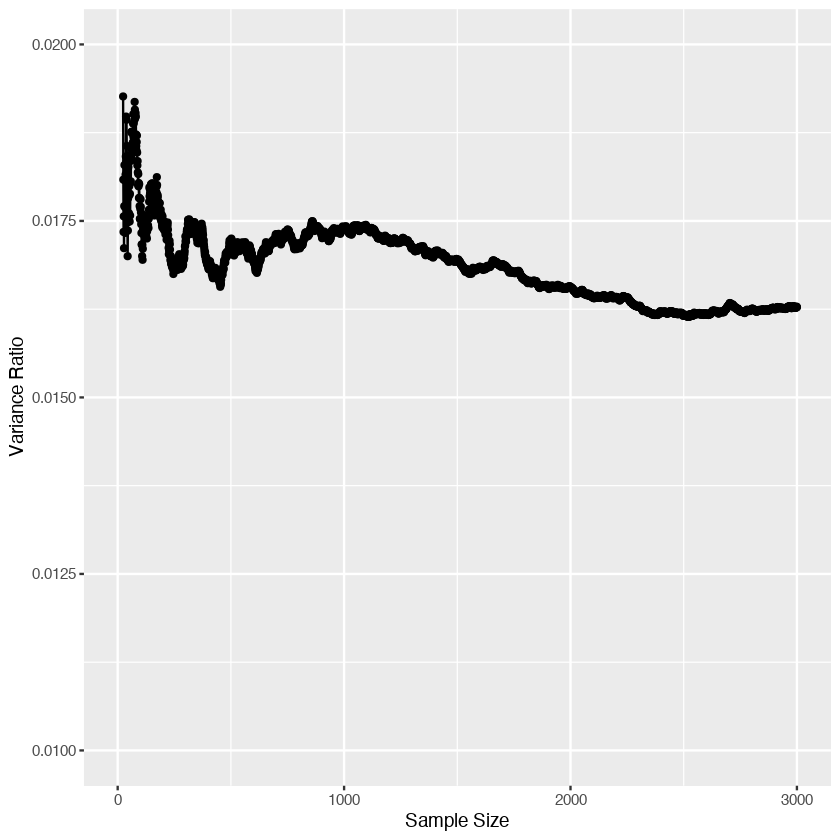

In [12]:
ggplot(RVdata, aes(x = nsamp, y = varratio)) +
    geom_point(shape = 16, col = "black", lwd = 1.7) + 
    geom_line(col = "black", linetype = 1) +
    ylim(0.01, 0.02) +
    xlab("Sample Size") + ylab("Variance Ratio")

### Control variable method

In estimating $I = E[f(X)]$, use another random variable $Y$ whose expectation $\mu$ is known. Note that $\hat{I} = f(X) - c(Y - \mu)$ is an unbiased estimator of $I$ for any $c$. Its variance is
$$
    \text{Var}[f(X) - c(Y - \mu)] = \text{Var}[f(X)] + c^2\text{Var}[Y] -2c \text{Cov}(f(X), Y)
    ,
$$
which is minimized by
$$
    c^{\star} = \frac{\text{Cov}(f(X), Y)}{\text{Var}[Y]}
    .
$$
and the minimum variance is
$$
    \text{Var}[f(X) - c^{\star}(Y - \mu)] = \text{Var}[f(X)] -\frac{\text{Cov}(f(X), Y)^2}{\text{Var}[Y]}
    .
$$

Thus if $f(X)$ and $Y$ are strongly correlated, then the variance reduces greatly.

The random variable $Y$ is called the control variable.

#### Example: exponential integral

$$
    I = \int_0^1 e^u du = e - 1 \approx 1.71828
$$

1. Naïve MC
$$
    \hat{I}_{\text{naive}} = \frac{1}{n}\sum_{i=1}^n \exp(U_i), \quad
    U_i \stackrel{iid}{\sim} \text{unif}(0, 1)
    .
$$
We have
\begin{align*}
    E[\hat{I}_{\text{naive}}] &= E[e^{U}] = I \\
    \text{Var}[\hat{I}_{\text{naive}}] &= \frac{1}{n}\text{Var}[e^U] = \frac{1}{n}\left(\frac{e^2-1}{2} - (e-1)^2\right) \approx \frac{0.2420}{n}.
\end{align*}

2. Antithetic MC
$$
    \hat{I}_{\text{an}} = \frac{1}{2n}\sum_{i=1}^n [\exp(U_i) + \exp(1 - U_i)], \quad
    U_i \stackrel{iid}{\sim} \text{unif}(0, 1)
    .
$$
We have 
\begin{align*}
    E[\hat{I}_{\text{as}}] &= \frac{1}{2}(E[e^U] + E[e^{1-U}]) = I \\
    \text{Var}[\hat{I}_{\text{as}}] &= \frac{1}{n}\text{Var}\left[\frac{e^U + e^{1-U}}{2}\right] = \frac{1}{n}\frac{\text{Var}[e^U] + \text{Var}[e^{1-U}] + 2\text{Cov}(e^U, e^{1-U})}{4} \\
    &= \frac{1}{4n}(e^2 - 1 - 2(e-1)^2 +  2(e - (e-1)^2) \\
    &\approx \frac{0.0039}{n}.
\end{align*}


3. Control variable MC
    - Use $U$ for a control variable.
$$    
    \text{Cov}(e^U, U) = E[Ue^U] - E[U]E[e^U] = \int_0^1 ue^u du - \frac{1}{2}(e - 1) = \frac{1}{2}(3 - e)
    \approx 0.14086
$$
Then
$$
    c^{\star} = \frac{\text{Cov}(e^U, U)}{\text{Var}[U]} = \frac{(3 - e)/2}{1/12} \approx 1.6903
$$
and the control variable estimator is
$$
    \hat{I}_{\text{cv}} = \frac{1}{n}\sum_{i=1}^n\left(\exp(U_i) - c^{\star}(U_i - 1/2)\right)
$$
with variance
$$
    \text{Var}[\hat{I}_{\text{cv}}] = \frac{1}{n}\text{Var}[e^U - c^{\star}(U - 1/2)]
    ,
$$
where
\begin{align*}
\text{Var}[e^U - c^{\star}(U - 1/2)] &= \text{Var}[e^U] -\frac{\text{Cov}(e^U, U)^2}{\text{Var}[Y]} \\
&= \frac{4e - 3 - e^2}{2} - 12\left(\frac{3-e}{2}\right)^2 
\approx 0.0039
.
\end{align*}
Therefore
$$
    \hat{I}_{\text{cv}} \approx \frac{0.0039}{n}
    .
$$

If we can choose $c$ well (e.g., by regression), then the variance reduces.

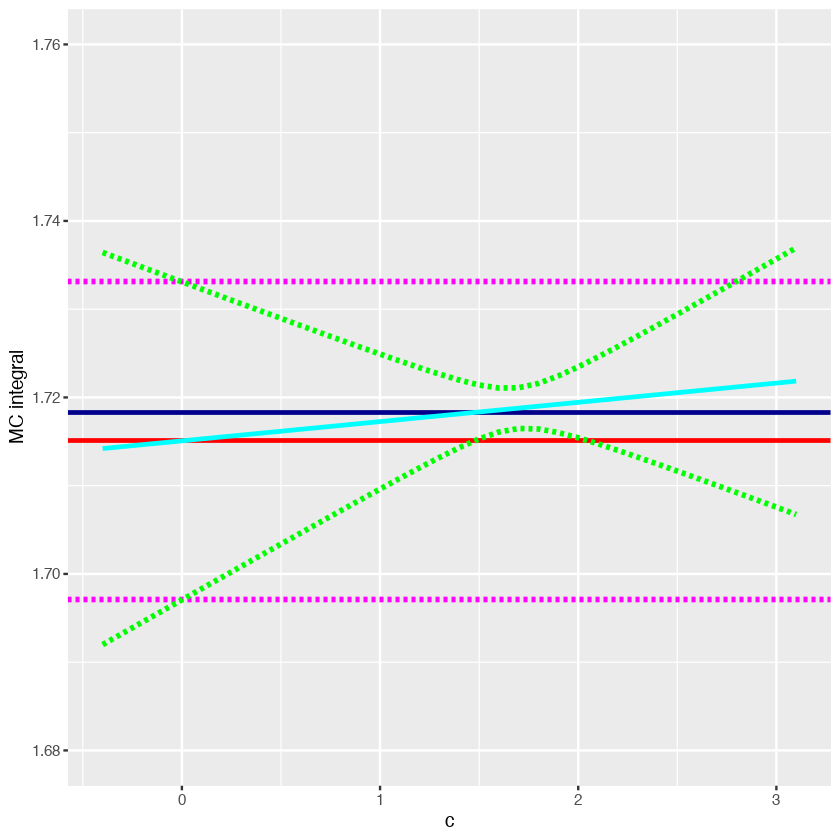

In [13]:
# continued from the previous example

#cstar <- 1.6903

cvals <- seq(-0.4, 3.1, by = 0.1)
nsim <- length(cvals)

ctrlMC <- numeric(nsim)
ctrlSD <- numeric(nsim)
varrate <- numeric(nsim)

for (k in seq_along(cvals)) {
    cstar <- cvals[k]
    ctrl <- exp(u) - cstar * (u - 0.5)
    ctrlMC[k]  <- mean(ctrl)
    ctrlSD[k]  <- sd(ctrl) / sqrt(nsamp)
    varrate[k] <- (ctrlSD[k] / naiveSD[length(naiveSD)])^2
}

RVdata <- data.frame(c = cvals, 
                     ctrlMC = ctrlMC,
                     ctrlUpper = ctrlMC + 2 * ctrlSD, ctrlLower = ctrlMC - 2 * ctrlSD,
                     varratio = varrate)
ggplot(RVdata, aes(x = c, y = ctrlMC)) +
    geom_hline(yintercept = naiveMC[length(naiveMC)], col = "red", lwd = 1) +
    #geom_point(shape = 16, col = "black", lwd = 1.7) +
    geom_hline(yintercept = exp(1) - 1, col = "dark blue", lwd = 1) +
    geom_hline(yintercept = naiveMC[length(naiveMC)] + 2 * naiveSD[length(naiveSD)], col = "magenta", lwd = 1.2, linetype = 2) +
    geom_hline(yintercept = naiveMC[length(naiveMC)] - 2 * naiveSD[length(naiveSD)], col = "magenta", lwd = 1.2, linetype = 2) +
    ylim(1.68, 1.76) +
    xlab("c") + ylab("MC integral") +
    geom_line(aes(x = c, y = ctrlMC), col = "cyan", lwd = 1) +
    #geom_point(shape = 16, col = "black", lwd = 1.7) + 
    geom_line(aes(x = c, y = ctrlUpper), col = "green", lwd = 1.2, linetype = 2) + 
    geom_line(aes(x = c, y = ctrlLower), col = "green", lwd = 1.2, linetype = 2) 

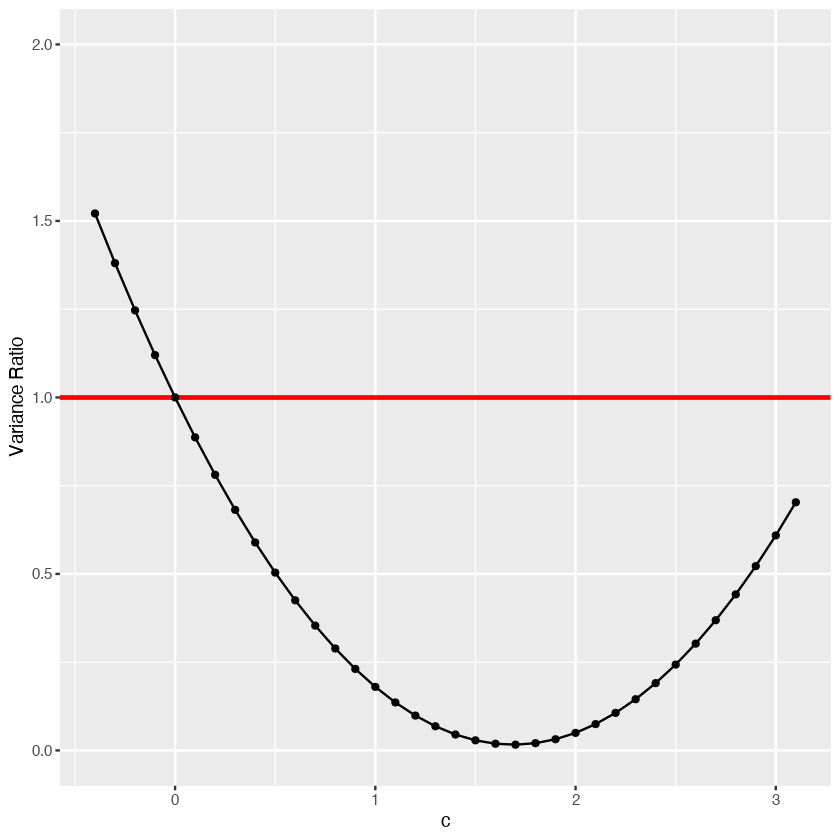

In [14]:
ggplot(RVdata, aes(x = c, y = varratio)) +
    geom_hline(yintercept = 1.0, col = "red", lwd = 1) +
    geom_point(shape = 16, col = "black", lwd = 1.7) + 
    geom_line(col = "black", linetype = 1) +
    ylim(0.0, 2.0) +
    xlab("c") + ylab("Variance Ratio")